##### Copyright 2018 Google LLC.

Licensed under the Apache License, Version 2.0 (the "License");

In [0]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Activation Grids -- Building Blocks of Interpretability

This colab notebook is part of our **Building Blocks of Intepretability** series exploring how intepretability techniques combine together to explain neural networks. If you haven't already, make sure to look at the [**corresponding paper**](https://distill.pub/2018/building-blocks) as well!

The notebook studies **activation grids** a technique for visualizing how a network "understood" an image at a particular layer.

<br>
<img src="https://storage.googleapis.com/lucid-static/building-blocks/notebook_heroes/activation-grid.jpeg" width="750"></img>
<br>

This tutorial is based on [**Lucid**](https://github.com/tensorflow/lucid), a network for visualizing neural networks. Lucid is a kind of spiritual successor to DeepDream, but provides flexible abstractions so that it can be used for a wide range of interpretability research.

**Note**: The easiest way to use this tutorial is [as a colab notebook](), which allows you to dive in with no setup. We recommend you enable a free GPU by going:

> **Runtime**   →   **Change runtime type**   →   **Hardware Accelerator: GPU**

Thanks for trying Lucid!

# Install / Import

In [0]:
!pip install --quiet lucid==0.3.8
%tensorflow_version 1.x

import numpy as np
import tensorflow as tf

import lucid.modelzoo.vision_models as models
from lucid.misc.io import show
import lucid.optvis.objectives as objectives
import lucid.optvis.param as param
import lucid.optvis.render as render
import lucid.optvis.transform as transform
from lucid.misc.channel_reducer import ChannelReducer
import sys
import imageio
from google.colab import files

from lucid.misc.io import show, load
from skimage.transform import resize

TensorFlow 1.x selected.


In [0]:
tf.logging.set_verbosity(tf.logging.ERROR)

In [0]:
#model = models.InceptionV1()
model = models.ResnetV1_50_slim()
#model = models.ResnetV2_50_slim()  # it seems broken :(
model.load_graphdef()

# Imagenet classes

In [0]:
imagenet_classes = [
  "background",
  "tench",
  "goldfish",
  "great white shark",
  "tiger shark",
  "hammerhead",
  "electric ray",
  "stingray",
  "cock",
  "hen",
  "ostrich",
  "brambling",
  "goldfinch",
  "house finch",
  "junco",
  "indigo bunting",
  "robin",
  "bulbul",
  "jay",
  "magpie",
  "chickadee",
  "water ouzel",
  "kite",
  "bald eagle",
  "vulture",
  "great grey owl",
  "European fire salamander",
  "common newt",
  "eft",
  "spotted salamander",
  "axolotl",
  "bullfrog",
  "tree frog",
  "tailed frog",
  "loggerhead",
  "leatherback turtle",
  "mud turtle",
  "terrapin",
  "box turtle",
  "banded gecko",
  "common iguana",
  "American chameleon",
  "whiptail",
  "agama",
  "frilled lizard",
  "alligator lizard",
  "Gila monster",
  "green lizard",
  "African chameleon",
  "Komodo dragon",
  "African crocodile",
  "American alligator",
  "triceratops",
  "thunder snake",
  "ringneck snake",
  "hognose snake",
  "green snake",
  "king snake",
  "garter snake",
  "water snake",
  "vine snake",
  "night snake",
  "boa constrictor",
  "rock python",
  "Indian cobra",
  "green mamba",
  "sea snake",
  "horned viper",
  "diamondback",
  "sidewinder",
  "trilobite",
  "harvestman",
  "scorpion",
  "black and gold garden spider",
  "barn spider",
  "garden spider",
  "black widow",
  "tarantula",
  "wolf spider",
  "tick",
  "centipede",
  "black grouse",
  "ptarmigan",
  "ruffed grouse",
  "prairie chicken",
  "peacock",
  "quail",
  "partridge",
  "African grey",
  "macaw",
  "sulphur-crested cockatoo",
  "lorikeet",
  "coucal",
  "bee eater",
  "hornbill",
  "hummingbird",
  "jacamar",
  "toucan",
  "drake",
  "red-breasted merganser",
  "goose",
  "black swan",
  "tusker",
  "echidna",
  "platypus",
  "wallaby",
  "koala",
  "wombat",
  "jellyfish",
  "sea anemone",
  "brain coral",
  "flatworm",
  "nematode",
  "conch",
  "snail",
  "slug",
  "sea slug",
  "chiton",
  "chambered nautilus",
  "Dungeness crab",
  "rock crab",
  "fiddler crab",
  "king crab",
  "American lobster",
  "spiny lobster",
  "crayfish",
  "hermit crab",
  "isopod",
  "white stork",
  "black stork",
  "spoonbill",
  "flamingo",
  "little blue heron",
  "American egret",
  "bittern",
  "crane",
  "limpkin",
  "European gallinule",
  "American coot",
  "bustard",
  "ruddy turnstone",
  "red-backed sandpiper",
  "redshank",
  "dowitcher",
  "oystercatcher",
  "pelican",
  "king penguin",
  "albatross",
  "grey whale",
  "killer whale",
  "dugong",
  "sea lion",
  "Chihuahua",
  "Japanese spaniel",
  "Maltese dog",
  "Pekinese",
  "Shih-Tzu",
  "Blenheim spaniel",
  "papillon",
  "toy terrier",
  "Rhodesian ridgeback",
  "Afghan hound",
  "basset",
  "beagle",
  "bloodhound",
  "bluetick",
  "black-and-tan coonhound",
  "Walker hound",
  "English foxhound",
  "redbone",
  "borzoi",
  "Irish wolfhound",
  "Italian greyhound",
  "whippet",
  "Ibizan hound",
  "Norwegian elkhound",
  "otterhound",
  "Saluki",
  "Scottish deerhound",
  "Weimaraner",
  "Staffordshire bullterrier",
  "American Staffordshire terrier",
  "Bedlington terrier",
  "Border terrier",
  "Kerry blue terrier",
  "Irish terrier",
  "Norfolk terrier",
  "Norwich terrier",
  "Yorkshire terrier",
  "wire-haired fox terrier",
  "Lakeland terrier",
  "Sealyham terrier",
  "Airedale",
  "cairn",
  "Australian terrier",
  "Dandie Dinmont",
  "Boston bull",
  "miniature schnauzer",
  "giant schnauzer",
  "standard schnauzer",
  "Scotch terrier",
  "Tibetan terrier",
  "silky terrier",
  "soft-coated wheaten terrier",
  "West Highland white terrier",
  "Lhasa",
  "flat-coated retriever",
  "curly-coated retriever",
  "golden retriever",
  "Labrador retriever",
  "Chesapeake Bay retriever",
  "German short-haired pointer",
  "vizsla",
  "English setter",
  "Irish setter",
  "Gordon setter",
  "Brittany spaniel",
  "clumber",
  "English springer",
  "Welsh springer spaniel",
  "cocker spaniel",
  "Sussex spaniel",
  "Irish water spaniel",
  "kuvasz",
  "schipperke",
  "groenendael",
  "malinois",
  "briard",
  "kelpie",
  "komondor",
  "Old English sheepdog",
  "Shetland sheepdog",
  "collie",
  "Border collie",
  "Bouvier des Flandres",
  "Rottweiler",
  "German shepherd",
  "Doberman",
  "miniature pinscher",
  "Greater Swiss Mountain dog",
  "Bernese mountain dog",
  "Appenzeller",
  "EntleBucher",
  "boxer",
  "bull mastiff",
  "Tibetan mastiff",
  "French bulldog",
  "Great Dane",
  "Saint Bernard",
  "Eskimo dog",
  "malamute",
  "Siberian husky",
  "dalmatian",
  "affenpinscher",
  "basenji",
  "pug",
  "Leonberg",
  "Newfoundland",
  "Great Pyrenees",
  "Samoyed",
  "Pomeranian",
  "chow",
  "keeshond",
  "Brabancon griffon",
  "Pembroke",
  "Cardigan",
  "toy poodle",
  "miniature poodle",
  "standard poodle",
  "Mexican hairless",
  "timber wolf",
  "white wolf",
  "red wolf",
  "coyote",
  "dingo",
  "dhole",
  "African hunting dog",
  "hyena",
  "red fox",
  "kit fox",
  "Arctic fox",
  "grey fox",
  "tabby",
  "tiger cat",
  "Persian cat",
  "Siamese cat",
  "Egyptian cat",
  "cougar",
  "lynx",
  "leopard",
  "snow leopard",
  "jaguar",
  "lion",
  "tiger",
  "cheetah",
  "brown bear",
  "American black bear",
  "ice bear",
  "sloth bear",
  "mongoose",
  "meerkat",
  "tiger beetle",
  "ladybug",
  "ground beetle",
  "long-horned beetle",
  "leaf beetle",
  "dung beetle",
  "rhinoceros beetle",
  "weevil",
  "fly",
  "bee",
  "ant",
  "grasshopper",
  "cricket",
  "walking stick",
  "cockroach",
  "mantis",
  "cicada",
  "leafhopper",
  "lacewing",
  "dragonfly",
  "damselfly",
  "admiral",
  "ringlet",
  "monarch",
  "cabbage butterfly",
  "sulphur butterfly",
  "lycaenid",
  "starfish",
  "sea urchin",
  "sea cucumber",
  "wood rabbit",
  "hare",
  "Angora",
  "hamster",
  "porcupine",
  "fox squirrel",
  "marmot",
  "beaver",
  "guinea pig",
  "sorrel",
  "zebra",
  "hog",
  "wild boar",
  "warthog",
  "hippopotamus",
  "ox",
  "water buffalo",
  "bison",
  "ram",
  "bighorn",
  "ibex",
  "hartebeest",
  "impala",
  "gazelle",
  "Arabian camel",
  "llama",
  "weasel",
  "mink",
  "polecat",
  "black-footed ferret",
  "otter",
  "skunk",
  "badger",
  "armadillo",
  "three-toed sloth",
  "orangutan",
  "gorilla",
  "chimpanzee",
  "gibbon",
  "siamang",
  "guenon",
  "patas",
  "baboon",
  "macaque",
  "langur",
  "colobus",
  "proboscis monkey",
  "marmoset",
  "capuchin",
  "howler monkey",
  "titi",
  "spider monkey",
  "squirrel monkey",
  "Madagascar cat",
  "indri",
  "Indian elephant",
  "African elephant",
  "lesser panda",
  "giant panda",
  "barracouta",
  "eel",
  "coho",
  "rock beauty",
  "anemone fish",
  "sturgeon",
  "gar",
  "lionfish",
  "puffer",
  "abacus",
  "abaya",
  "academic gown",
  "accordion",
  "acoustic guitar",
  "aircraft carrier",
  "airliner",
  "airship",
  "altar",
  "ambulance",
  "amphibian",
  "analog clock",
  "apiary",
  "apron",
  "ashcan",
  "assault rifle",
  "backpack",
  "bakery",
  "balance beam",
  "balloon",
  "ballpoint",
  "Band Aid",
  "banjo",
  "bannister",
  "barbell",
  "barber chair",
  "barbershop",
  "barn",
  "barometer",
  "barrel",
  "barrow",
  "baseball",
  "basketball",
  "bassinet",
  "bassoon",
  "bathing cap",
  "bath towel",
  "bathtub",
  "beach wagon",
  "beacon",
  "beaker",
  "bearskin",
  "beer bottle",
  "beer glass",
  "bell cote",
  "bib",
  "bicycle-built-for-two",
  "bikini",
  "binder",
  "binoculars",
  "birdhouse",
  "boathouse",
  "bobsled",
  "bolo tie",
  "bonnet",
  "bookcase",
  "bookshop",
  "bottlecap",
  "bow",
  "bow tie",
  "brass",
  "brassiere",
  "breakwater",
  "breastplate",
  "broom",
  "bucket",
  "buckle",
  "bulletproof vest",
  "bullet train",
  "butcher shop",
  "cab",
  "caldron",
  "candle",
  "cannon",
  "canoe",
  "can opener",
  "cardigan",
  "car mirror",
  "carousel",
  "carpenter's kit",
  "carton",
  "car wheel",
  "cash machine",
  "cassette",
  "cassette player",
  "castle",
  "catamaran",
  "CD player",
  "cello",
  "cellular telephone",
  "chain",
  "chainlink fence",
  "chain mail",
  "chain saw",
  "chest",
  "chiffonier",
  "chime",
  "china cabinet",
  "Christmas stocking",
  "church",
  "cinema",
  "cleaver",
  "cliff dwelling",
  "cloak",
  "clog",
  "cocktail shaker",
  "coffee mug",
  "coffeepot",
  "coil",
  "combination lock",
  "computer keyboard",
  "confectionery",
  "container ship",
  "convertible",
  "corkscrew",
  "cornet",
  "cowboy boot",
  "cowboy hat",
  "cradle",
  "crane",
  "crash helmet",
  "crate",
  "crib",
  "Crock Pot",
  "croquet ball",
  "crutch",
  "cuirass",
  "dam",
  "desk",
  "desktop computer",
  "dial telephone",
  "diaper",
  "digital clock",
  "digital watch",
  "dining table",
  "dishrag",
  "dishwasher",
  "disk brake",
  "dock",
  "dogsled",
  "dome",
  "doormat",
  "drilling platform",
  "drum",
  "drumstick",
  "dumbbell",
  "Dutch oven",
  "electric fan",
  "electric guitar",
  "electric locomotive",
  "entertainment center",
  "envelope",
  "espresso maker",
  "face powder",
  "feather boa",
  "file",
  "fireboat",
  "fire engine",
  "fire screen",
  "flagpole",
  "flute",
  "folding chair",
  "football helmet",
  "forklift",
  "fountain",
  "fountain pen",
  "four-poster",
  "freight car",
  "French horn",
  "frying pan",
  "fur coat",
  "garbage truck",
  "gasmask",
  "gas pump",
  "goblet",
  "go-kart",
  "golf ball",
  "golfcart",
  "gondola",
  "gong",
  "gown",
  "grand piano",
  "greenhouse",
  "grille",
  "grocery store",
  "guillotine",
  "hair slide",
  "hair spray",
  "half track",
  "hammer",
  "hamper",
  "hand blower",
  "hand-held computer",
  "handkerchief",
  "hard disc",
  "harmonica",
  "harp",
  "harvester",
  "hatchet",
  "holster",
  "home theater",
  "honeycomb",
  "hook",
  "hoopskirt",
  "horizontal bar",
  "horse cart",
  "hourglass",
  "iPod",
  "iron",
  "jack-o'-lantern",
  "jean",
  "jeep",
  "jersey",
  "jigsaw puzzle",
  "jinrikisha",
  "joystick",
  "kimono",
  "knee pad",
  "knot",
  "lab coat",
  "ladle",
  "lampshade",
  "laptop",
  "lawn mower",
  "lens cap",
  "letter opener",
  "library",
  "lifeboat",
  "lighter",
  "limousine",
  "liner",
  "lipstick",
  "Loafer",
  "lotion",
  "loudspeaker",
  "loupe",
  "lumbermill",
  "magnetic compass",
  "mailbag",
  "mailbox",
  "maillot",
  "maillot",
  "manhole cover",
  "maraca",
  "marimba",
  "mask",
  "matchstick",
  "maypole",
  "maze",
  "measuring cup",
  "medicine chest",
  "megalith",
  "microphone",
  "microwave",
  "military uniform",
  "milk can",
  "minibus",
  "miniskirt",
  "minivan",
  "missile",
  "mitten",
  "mixing bowl",
  "mobile home",
  "Model T",
  "modem",
  "monastery",
  "monitor",
  "moped",
  "mortar",
  "mortarboard",
  "mosque",
  "mosquito net",
  "motor scooter",
  "mountain bike",
  "mountain tent",
  "mouse",
  "mousetrap",
  "moving van",
  "muzzle",
  "nail",
  "neck brace",
  "necklace",
  "nipple",
  "notebook",
  "obelisk",
  "oboe",
  "ocarina",
  "odometer",
  "oil filter",
  "organ",
  "oscilloscope",
  "overskirt",
  "oxcart",
  "oxygen mask",
  "packet",
  "paddle",
  "paddlewheel",
  "padlock",
  "paintbrush",
  "pajama",
  "palace",
  "panpipe",
  "paper towel",
  "parachute",
  "parallel bars",
  "park bench",
  "parking meter",
  "passenger car",
  "patio",
  "pay-phone",
  "pedestal",
  "pencil box",
  "pencil sharpener",
  "perfume",
  "Petri dish",
  "photocopier",
  "pick",
  "pickelhaube",
  "picket fence",
  "pickup",
  "pier",
  "piggy bank",
  "pill bottle",
  "pillow",
  "ping-pong ball",
  "pinwheel",
  "pirate",
  "pitcher",
  "plane",
  "planetarium",
  "plastic bag",
  "plate rack",
  "plow",
  "plunger",
  "Polaroid camera",
  "pole",
  "police van",
  "poncho",
  "pool table",
  "pop bottle",
  "pot",
  "potter's wheel",
  "power drill",
  "prayer rug",
  "printer",
  "prison",
  "projectile",
  "projector",
  "puck",
  "punching bag",
  "purse",
  "quill",
  "quilt",
  "racer",
  "racket",
  "radiator",
  "radio",
  "radio telescope",
  "rain barrel",
  "recreational vehicle",
  "reel",
  "reflex camera",
  "refrigerator",
  "remote control",
  "restaurant",
  "revolver",
  "rifle",
  "rocking chair",
  "rotisserie",
  "rubber eraser",
  "rugby ball",
  "rule",
  "running shoe",
  "safe",
  "safety pin",
  "saltshaker",
  "sandal",
  "sarong",
  "sax",
  "scabbard",
  "scale",
  "school bus",
  "schooner",
  "scoreboard",
  "screen",
  "screw",
  "screwdriver",
  "seat belt",
  "sewing machine",
  "shield",
  "shoe shop",
  "shoji",
  "shopping basket",
  "shopping cart",
  "shovel",
  "shower cap",
  "shower curtain",
  "ski",
  "ski mask",
  "sleeping bag",
  "slide rule",
  "sliding door",
  "slot",
  "snorkel",
  "snowmobile",
  "snowplow",
  "soap dispenser",
  "soccer ball",
  "sock",
  "solar dish",
  "sombrero",
  "soup bowl",
  "space bar",
  "space heater",
  "space shuttle",
  "spatula",
  "speedboat",
  "spider web",
  "spindle",
  "sports car",
  "spotlight",
  "stage",
  "steam locomotive",
  "steel arch bridge",
  "steel drum",
  "stethoscope",
  "stole",
  "stone wall",
  "stopwatch",
  "stove",
  "strainer",
  "streetcar",
  "stretcher",
  "studio couch",
  "stupa",
  "submarine",
  "suit",
  "sundial",
  "sunglass",
  "sunglasses",
  "sunscreen",
  "suspension bridge",
  "swab",
  "sweatshirt",
  "swimming trunks",
  "swing",
  "switch",
  "syringe",
  "table lamp",
  "tank",
  "tape player",
  "teapot",
  "teddy",
  "television",
  "tennis ball",
  "thatch",
  "theater curtain",
  "thimble",
  "thresher",
  "throne",
  "tile roof",
  "toaster",
  "tobacco shop",
  "toilet seat",
  "torch",
  "totem pole",
  "tow truck",
  "toyshop",
  "tractor",
  "trailer truck",
  "tray",
  "trench coat",
  "tricycle",
  "trimaran",
  "tripod",
  "triumphal arch",
  "trolleybus",
  "trombone",
  "tub",
  "turnstile",
  "typewriter keyboard",
  "umbrella",
  "unicycle",
  "upright",
  "vacuum",
  "vase",
  "vault",
  "velvet",
  "vending machine",
  "vestment",
  "viaduct",
  "violin",
  "volleyball",
  "waffle iron",
  "wall clock",
  "wallet",
  "wardrobe",
  "warplane",
  "washbasin",
  "washer",
  "water bottle",
  "water jug",
  "water tower",
  "whiskey jug",
  "whistle",
  "wig",
  "window screen",
  "window shade",
  "Windsor tie",
  "wine bottle",
  "wing",
  "wok",
  "wooden spoon",
  "wool",
  "worm fence",
  "wreck",
  "yawl",
  "yurt",
  "web site",
  "comic book",
  "crossword puzzle",
  "street sign",
  "traffic light",
  "book jacket",
  "menu",
  "plate",
  "guacamole",
  "consomme",
  "hot pot",
  "trifle",
  "ice cream",
  "ice lolly",
  "French loaf",
  "bagel",
  "pretzel",
  "cheeseburger",
  "hotdog",
  "mashed potato",
  "head cabbage",
  "broccoli",
  "cauliflower",
  "zucchini",
  "spaghetti squash",
  "acorn squash",
  "butternut squash",
  "cucumber",
  "artichoke",
  "bell pepper",
  "cardoon",
  "mushroom",
  "Granny Smith",
  "strawberry",
  "orange",
  "lemon",
  "fig",
  "pineapple",
  "banana",
  "jackfruit",
  "custard apple",
  "pomegranate",
  "hay",
  "carbonara",
  "chocolate sauce",
  "dough",
  "meat loaf",
  "pizza",
  "potpie",
  "burrito",
  "red wine",
  "espresso",
  "cup",
  "eggnog",
  "alp",
  "bubble",
  "cliff",
  "coral reef",
  "geyser",
  "lakeside",
  "promontory",
  "sandbar",
  "seashore",
  "valley",
  "volcano",
  "ballplayer",
  "groom",
  "scuba diver",
  "rapeseed",
  "daisy",
  "yellow lady's slipper",
  "corn",
  "acorn",
  "hip",
  "buckeye",
  "coral fungus",
  "agaric",
  "gyromitra",
  "stinkhorn",
  "earthstar",
  "hen-of-the-woods",
  "bolete",
  "ear",
  "toilet tissue",
]

# Execution

In [0]:
def render_activation_grid_less_naive(img, model, layers, layer_num, W=42,
                                 n_groups=6, subsample_factor=1, n_steps=256):
  
  layer = layers[layer_num]
  print(img.shape)
  desperation_factor = 2
  area_ratio = (desperation_factor * img.shape[0] * img.shape[1] / 224 ** 2) ** (1/2) 
  new_shape = (img.shape[0] // area_ratio,
               img.shape[1] // area_ratio)
  img = resize(img, new_shape)
  print(img.shape)

  # Get the activations
  with tf.Graph().as_default(), tf.Session() as sess:
    t_input = tf.placeholder("float32", [None, None, None, 3])
    T = render.import_model(model, t_input, t_input)
    acts = T(layer).eval({t_input: img[None]})[0]
    pred = T(layers[-1]).eval({t_input: img[None]})[0]
    
  ###########################################
  # predict
  index = np.argmax(pred)
  prediction = imagenet_classes[index]
  confidence = pred[index]
  print(f'class:\t\t {prediction}')
  print(f'confidence:\t {confidence}')
  ###########################################
  
  acts_flat = acts.reshape([-1] + [acts.shape[2]])
  N = acts_flat.shape[0]
  
  # The trick to avoiding "decoherence" is to recognize images that are
  # for similar activation vectors and 
  if n_groups > 0:
    reducer = ChannelReducer(n_groups, "NMF")
    groups = reducer.fit_transform(acts_flat)
    groups /= groups.max(0)
  else:
    groups = np.zeros([])
    
  print(groups.shape)

  
  # The key trick to increasing memory efficiency is random sampling.
  # Even though we're visualizing lots of images, we only run a small
  # subset through the network at once. In order to do this, we'll need
  # to hold tensors in a tensorflow graph around the visualization process.
  
  with tf.Graph().as_default() as graph, tf.Session() as sess:
    
    
    # Using the groups, create a paramaterization of images that
    # partly shares paramters between the images for similar activation
    # vectors. Each one still has a full set of unique parameters, and could
    # optimize to any image. We're just making it easier to find solutions
    # where things are the same.
    group_imgs_raw = param.fft_image([n_groups, W, W, 3])
    unique_imgs_raw = param.fft_image([N, W, W, 3])
    opt_imgs = param.to_valid_rgb(tf.stack([
            0.7*unique_imgs_raw[i] + 
            0.5*sum(groups[i, j] * group_imgs_raw[j] for j in range(n_groups))
            for i in range(N) ]),
            decorrelate=True)
    
    # Construct a random batch to optimize this step
    batch_size = 64
    rand_inds = tf.random_uniform([batch_size], 0, N, dtype=tf.int32)
    pres_imgs = tf.gather(opt_imgs, rand_inds)
    pres_acts = tf.gather(acts_flat, rand_inds)
    obj = objectives.Objective.sum(
      [objectives.direction(layer, pres_acts[n], batch=n)
       for n in range(batch_size)
      ])
    
    
    # Actually do the optimization...
    T = render.make_vis_T(model, obj, param_f=pres_imgs)
    tf.global_variables_initializer().run()
    
    print('_' * (n_steps // (16*2)))
    for i in range(n_steps):
      T("vis_op").run()
      if (i+1) % (16) == 0:
        print('>', end='')
      if (i+1) % (n_steps//2) == 0:
        show(pres_imgs.eval()[::4])
    
    vis_imgs = opt_imgs.eval()
    
  # Combine the images and display the resulting grid
  print("")
  vis_imgs_ = vis_imgs.reshape(list(acts.shape[:2]) + [W, W, 3])
  vis_imgs_cropped = vis_imgs_[:, :, 2:-2, 2:-2, :]
  final_image = np.hstack(np.hstack(vis_imgs_cropped))
  # show(final_image)
  img_name = f'layer{layer_num}_{prediction}_{confidence}.jpg'
  imageio.imwrite(img_name, final_image)
  return img_name
  # return vis_imgs_cropped

In [0]:
# layers for inception from https://github.com/tensorflow/lucid/blob/master/lucid/modelzoo/other_models/InceptionV1.py

resnet_layers = [
  'resnet_v1_50/conv1/Relu',
  'resnet_v1_50/block1/unit_1/bottleneck_v1/Relu',
  'resnet_v1_50/block1/unit_2/bottleneck_v1/Relu',
  'resnet_v1_50/block1/unit_3/bottleneck_v1/Relu',
  'resnet_v1_50/block2/unit_1/bottleneck_v1/Relu',
  'resnet_v1_50/block2/unit_2/bottleneck_v1/Relu',
  'resnet_v1_50/block2/unit_3/bottleneck_v1/Relu',
  'resnet_v1_50/block2/unit_4/bottleneck_v1/Relu',
  'resnet_v1_50/block3/unit_1/bottleneck_v1/Relu',
  'resnet_v1_50/block3/unit_2/bottleneck_v1/Relu',
  'resnet_v1_50/block3/unit_3/bottleneck_v1/Relu',
  'resnet_v1_50/block3/unit_4/bottleneck_v1/Relu',
  'resnet_v1_50/block3/unit_5/bottleneck_v1/Relu',
  'resnet_v1_50/block3/unit_6/bottleneck_v1/Relu',
  'resnet_v1_50/block4/unit_1/bottleneck_v1/Relu',
  'resnet_v1_50/block4/unit_2/bottleneck_v1/Relu',
  'resnet_v1_50/block4/unit_3/bottleneck_v1/Relu',
  'resnet_v1_50/predictions/Softmax', 
]

(800, 1000, 3)
(141, 177, 3)
class:		 red fox
confidence:	 0.5016228556632996
(108, 6)
________________________________
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


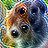
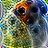
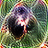
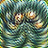
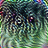
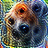
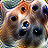
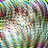
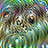
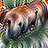
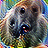
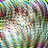
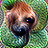
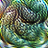
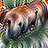
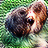

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


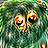
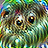
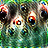
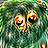
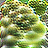
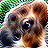
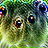
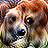
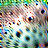
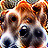
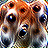
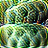
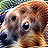
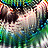
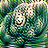
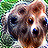

In [0]:
# layer names from https://github.com/tensorflow/lucid/blob/master/lucid/modelzoo/slim_models/ResNetV1.py

frog_as_snowmobile = 'https://raw.githubusercontent.com/fsondej/explainator/master/data/best_of_imagenet_a/frog_as_snowmobile/0.005290_snowmobile%20_%20snowmobile_0.71322095.jpg'
frog_as_squirrel = 'https://raw.githubusercontent.com/fsondej/explainator/master/data/best_of_imagenet_a/frog_as_squirell/0.001567_fox%20squirrel%20_%20fox%20squirrel_0.99593735.jpg'
frog_real = 'https://raw.githubusercontent.com/fsondej/explainator/master/data/best_of_imagenet_a/frog_as_squirell/real_frog.jpg'
fox_real = 'https://raw.githubusercontent.com/fsondej/explainator/master/data/best_of_imagenet_a/frog_as_squirell/real_fox.jpg'
img = load(fox_real)
img_name = render_activation_grid_less_naive(img, model, W=48, n_steps=1024,
              layers=resnet_layers,
              layer_num=9)

In [0]:
files.download('/content/' + img_name)
# files.download('/content/*')